In [1]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torchshow as ts
import IPython.display as ipd
import os
import pandas as pd
import torchaudio
import torchshow as ts
import librosa

In [2]:
# Dense Block
class DenseBlock(nn.Module):
    def __init__(self, in_channels):
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels+8, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels+2*8, 8, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels+3*8, 8, kernel_size=3, padding=1)

    def forward(self, x):
            x1 = F.relu(self.conv1(x))
            x2 = F.relu(self.conv2(torch.cat([x, x1], dim=1)))
            x3 = F.relu(self.conv3(torch.cat([x, x1, x2], dim=1)))
            x4 = F.relu(self.conv4(torch.cat([x, x1, x2, x3], dim=1)))
            out = torch.cat([x, x1, x2, x3, x4], dim=1)
            return out
    

    
# Transition Down
class TransitionDown(nn.Module):
    def __init__(self, in_channels, stride):
        super(TransitionDown, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=(2, 1), stride=(stride, 1),ceil_mode=True)

    def forward(self, x):
        x = F.relu(self.conv(x))
        out = self.avg_pool(x)
        return out
    
# Transition Expand
class TransitionExpand(nn.Module):
    def __init__(self, in_channels, out_channels=16, stride=1):
        super(TransitionExpand, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=(2, 1), stride=(stride, 1),ceil_mode=True)

    def forward(self, x):
        x = F.relu(self.conv(x))
        out = self.avg_pool(x)
        return out

tensor = torch.randn(size=(8, 2, 513, 600))  # Example batch of size 8
tdown = TransitionExpand(in_channels=2, stride=2)
out = tdown(tensor)

# Transition Up
class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels=16, stride=1):
        super(TransitionUp, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels=in_channels,
                                            out_channels=out_channels,
                                            kernel_size=(3, 1),
                                            stride=(stride, 1),
                                            padding=(1, 0),
                                            output_padding=0)

    def forward(self, x):
        out = F.relu(self.transconv(x))
        return out
    

# Transition Final
class TransitionFinal(nn.Module):
    def __init__(self, in_channels):
        super(TransitionFinal, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        out = self.conv(x)
        return out  # out.squeeze(1) would remove the singleton channel dimension
    

# Linear Compressor
class LinearCompressor(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearCompressor, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
        
    def forward(self, x):
        # Get the original shape
        orig_shape = x.shape
        
        # Reshape the tensor to be [batch_size, channel * 600, 69]
        x = x.view(orig_shape[0], -1, self.linear.in_features)
        
        # Apply the linear layer
        x = self.linear(x)
        
        # Apply the LeakyReLU activation
        x = self.leaky_relu(x)
        
        # Reshape the tensor back to the original shape but with the second dimension replaced
        x = x.view(orig_shape[0], orig_shape[1], self.linear.out_features, -1)
        
        return x



# Temporal Block
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TemporalBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 1), dilation=(1, 1))
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 2), dilation=(1, 2))
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 4), dilation=(1, 4))
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 8), dilation=(1, 8))

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out2 = self.relu(self.conv2(x))
        out3 = self.relu(self.conv3(x))
        out4 = self.relu(self.conv4(x))

        out = torch.cat((out1, out2, out3, out4), dim=1)  # Concatenate along the channel axis

        return out
    



In [3]:
# Alpha Model

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        # Encoder Blocks
        super(VariationalAutoencoder, self).__init__()
        self.block2 = DenseBlock(in_channels=2)
        self.block34 = DenseBlock(in_channels=34)
        self.block100 = DenseBlock(in_channels=100)
        self.block232 = DenseBlock(in_channels=232)

        self.transdown34_2 = TransitionDown(in_channels=34,stride=2)
        self.transdown34_4 = TransitionDown(in_channels=34,stride=4)
        self.transdown34_8 = TransitionDown(in_channels=34,stride=8)
        self.transdown66_2 = TransitionDown(in_channels=66,stride=2)
        self.transdown66_4 = TransitionDown(in_channels=66,stride=4)
        self.transdown132_2 = TransitionDown(in_channels=132,stride=2)

        self.transfinal = TransitionFinal(in_channels=264)
        self.linearCompressor = LinearCompressor(65,32)

        # Decoder Blocks
        ## Linear Block
        self.linearCompressorUp = LinearCompressor(32,65)

        ## Transition Up Blocks
        self.transup_4_8 = TransitionUp(4,16,8)
        self.transup_4_2 = TransitionUp(4,16,2)
        self.transup_4_4 = TransitionUp(4,16,4)
        self.transup_48_2 = TransitionUp(48,16,2)
        self.transup_48_4 = TransitionUp(48,16,4)
        self.transup_64_2 = TransitionUp(64,16,2)

        ## Dense Blocks
        self.block16 = DenseBlock(16)
        self.block32 = DenseBlock(32)
        self.block48 = DenseBlock(48)

        ## Transiton Final Blocks
        self.transfinal2 = TransitionFinal(in_channels=80)

        ## Temporal Block
        self.tempBlock = TemporalBlock(1,1)

    def encoder(self,x):
        x = self.block2(x)

        x1 = self.transdown34_8(x)
        x2 = self.transdown34_4(x) # required in cat
        x3 = self.transdown34_2(x)

        x3 = self.block34(x3)
        x3 = self.transdown66_2(x3)
        x4 = self.transdown66_2(x3)

        x2 = torch.cat([x2,x3],dim=1)
        x2 = self.block100(x2)
        x2 = self.transdown132_2(x2)

        x = torch.cat([x1,x2,x4],dim=1)

        mu = self.linearCompressor(self.transfinal(self.block232(x)))
        sigma = self.linearCompressor(self.transfinal(self.block232(x)))

        return mu, sigma

        
    def magnitude_decoder(self,z):
        z = self.tempBlock(z) # Temp Block
        z = self.linearCompressorUp(z) # Linear Layer

        z1 = self.transup_4_8(z)
        z2 = self.transup_4_4(z)
        z3 = self.transup_4_2(z)

        z3 = self.block16(z3)
        z3s = z3.clone()


        z3 = self.transup_48_2(z3)

        z2 = torch.cat([z2,z3],dim=1)
        z2 = self.block32(z2)
        z2 = self.transup_64_2(z2)
        z4 = self.transup_48_4(z3s)

        z1 = torch.cat([z1,z2,z4],dim=1)
        z2 = z1.clone()

        z1 = self.block48(z1)
        z2 = self.block48(z2)

        z1 = self.transfinal2(z1)
        z2 = self.transfinal2(z2)

        return z1, torch.exp(z2)

    def phase_decoder(self,z,est_mag,est_var):
        pass

    def forward(self,x):
        mu, sigma = self.encoder(x)
        epsilon = torch.randn_like(sigma)
        z_reparametrised = mu + sigma*epsilon
        var, x_reconstructed = self.magnitude_decoder(z_reparametrised)

        return x_reconstructed, mu, sigma

In [4]:
# Dataloader

class AvianNatureSounds(Dataset):
    def __init__(self, annotation_file=None, root_dir='./',mel_spectrogram = None,mode='wav'):
        self.annotation_file = pd.read_csv(annotation_file).sort_values('fileName')
        self.root_dir = root_dir
        self.mel_transformation = mel_spectrogram
        self.AmplitudeToDB = torchaudio.transforms.AmplitudeToDB()
        self.mode = mode


    def __len__(self):
        return len(self.annotation_file)

    def __getitem__(self, index):
        if self.mode == 'wav':
            audio_sample_path = os.path.join(self.root_dir,os.listdir(self.root_dir)[index])
            label = self.annotation_file.iloc[index]['habitat']
            signal, sr = torchaudio.load(audio_sample_path)

            return (signal, sr), label , audio_sample_path
        
        elif self.mode == 'mel':
            audio_sample_path = os.path.join(self.root_dir,os.listdir(self.root_dir)[index])
            label = self.annotation_file.iloc[index]['habitat']
            signal, sr = torchaudio.load(audio_sample_path)
            signal = self.AmplitudeToDB(self.mel_transformation(signal))

            # signal[:, 65:] = 0

            # return (signal, sr), label
            return signal, label
        
        elif self.mode == 'stft': 
            audio_sample_path = os.path.join(self.root_dir,os.listdir(self.root_dir)[index])
            label = self.annotation_file.iloc[index]['habitat']
            signal, sr = torchaudio.load(audio_sample_path)

            stft = torch.stft(signal, n_fft=1024, hop_length=512, normalized=True, return_complex=True)

            mag = self.AmplitudeToDB(torch.abs(stft))
            phase = torch.angle(stft)

            return torch.cat([mag,phase],dim=0), label
        
        elif self.mode == 'stft_mag': 
            audio_sample_path = os.path.join(self.root_dir,os.listdir(self.root_dir)[index])
            label = self.annotation_file.iloc[index]['habitat']
            signal, sr = torchaudio.load(audio_sample_path)

            stft = torch.stft(signal, n_fft=1024, hop_length=4096*2, normalized=True, return_complex=True)

            mag = self.AmplitudeToDB(torch.abs(stft))

            return mag, label
        
        elif self.mode == 'stft_phase': 
            audio_sample_path = os.path.join(self.root_dir,os.listdir(self.root_dir)[index])
            label = self.annotation_file.iloc[index]['habitat']
            signal, sr = torchaudio.load(audio_sample_path)

            stft = torch.stft(signal, n_fft=1024, hop_length=4096*2, normalized=True, return_complex=True) # see https://dsp.stackexchange.com/a/258

            phase = torch.angle(stft)

            return phase, label


        else:
            raise NotImplementedError

In [5]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                     n_fft=1024,
                                     hop_length=4096*2,
                                     n_mels=80)



data = AvianNatureSounds(annotation_file='../data/AvianID_AcousticIndices/UK_AI.csv',root_dir='../data/UK_BIRD/',mel_spectrogram=mel_spectrogram,mode='stft')

train_loader = DataLoader(dataset=data, batch_size=2, shuffle=False)
batch = next(iter(train_loader)) 

print(batch[0].shape)

torch.Size([2, 2, 513, 5626])


In [7]:
# Dataloader & Device
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
NUM_EPOCHS = 5
LR_RATE = 3e-3 # kaparthy constant

model = VariationalAutoencoder()
model = model.to(device)
optimiser = optim.AdamW(model.parameters(),lr=LR_RATE)
loss_fn = nn.MSELoss(reduction="mean")

In [8]:
# Training Loop

training_loss = []

for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader))
    for i, x in loop:
        # Forward pass
        x = x[0].to(device)

        x_reconstructed, mu, sigma = model(x)

        mag = x[:, 0:1, :, :]

        # Compute Loss
        reconstruction_loss = loss_fn(x_reconstructed,mag)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2)-sigma.pow(2))

        # backprop
        loss = reconstruction_loss + kl_div
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        loop.set_postfix(loss=loss.item())
        training_loss.append(loss.item())
    # ts.show(x_reconstructed)
        

14it [04:26, 19.04s/it, loss=4.02e+5]


KeyboardInterrupt: 

torch.Size([8, 513, 400])
(513, 400)


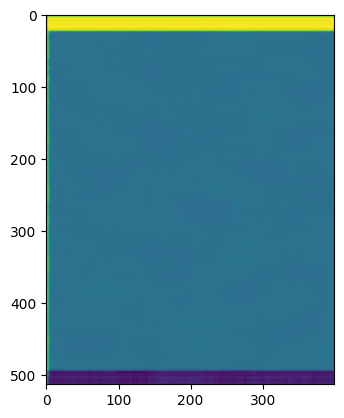

torch.Size([8, 2, 513, 400])
(2, 513, 400)


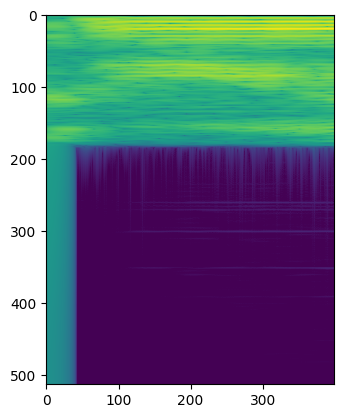

In [19]:
import matplotlib.pyplot as plt

# Assuming your tensor is named 'tensor'
# Transfer the tensor from GPU to CPU
tensor_cpu = x_reconstructed.cpu().detach().squeeze()

print(tensor_cpu.shape)

# Convert the torch tensor to a NumPy array
array = tensor_cpu[0].numpy()

print(array.shape)

# Display the array using matplotlib
plt.imshow(array)
plt.show()


# Assuming your tensor is named 'tensor'
# Transfer the tensor from GPU to CPU
tensor_cpu = x.cpu().detach().squeeze()

print(tensor_cpu.shape)

# Convert the torch tensor to a NumPy array
array = tensor_cpu[0].numpy()

print(array.shape)

# Display the array using matplotlib
plt.imshow(array[0])
plt.show()
